In [21]:
from scipy.optimize import NonlinearConstraint, minimize, LinearConstraint
import numpy as np
from scipy.special import gamma, factorial
import pandas as pd

In [43]:
h = -1.50
N = 100
gamma_const = 0.5
delta_const = 0.5
T = 1
X = 0.1
G = np.zeros((N, N))

def G_ij_upper(i, j):
    return (1 / (1 - gamma_const) * (1 - gamma_const)) * (T / N) ** (2 - gamma_const) \
            * ((i - j + 1) ** (2 - gamma_const) - 2 * (i - j) ** (2 - gamma_const) +\
                 (i - j - 1) ** (2 - gamma_const)) 

def G_ii_diagonal():
    return (2 / ((1 - gamma_const) * (2 - gamma_const))) * (T / N) ** (2 - gamma_const)
    
G_upper = np.fromfunction(G_ij_upper, (N, N))
G_upper = np.nan_to_num(G_upper, nan = 0.0)
G_diag = np.repeat(G_ii_diagonal(), N)
G_diag = np.diag(G_diag)
G = G_upper.T + G_upper + G_diag

v_guess = np.repeat(T * X / N, N) ## VWAP

def gss_guess(t: np.array) -> np.array:
    gamma_1 = gamma((1 + gamma_const)/ 2)
    gamma_2 = gamma(1 + (gamma_const / 2))
    c = (X / N) / (np.sqrt(np.pi) * (T / 2) ** gamma_const * (gamma_1 / gamma_2))
    return (c / (t * (T - t)) ** ((1 - gamma_const) / 2))
gss_v_0_guess = gss_guess(np.arange(0, 1 + 1 / (N + 1), 1 / (N + 1)))[1:-1]

<ipython-input-43-a1338dd835f3>:11: RuntimeWarning: invalid value encountered in power
  * ((i - j + 1) ** (2 - gamma_const) - 2 * (i - j) ** (2 - gamma_const) +\
<ipython-input-43-a1338dd835f3>:12: RuntimeWarning: invalid value encountered in power
  (i - j - 1) ** (2 - gamma_const))
<ipython-input-43-a1338dd835f3>:29: RuntimeWarning: divide by zero encountered in true_divide
  return (c / (t * (T - t)) ** ((1 - gamma_const) / 2))


In [44]:
def impact_f(v):
    return np.sign(v) * np.abs(v) ** delta_const

A = G_upper + G_diag / 2

def expect_cost_compute(v):
    return v @ A @ impact_f(v).T

In [45]:
def total_volume_cons(x):
    return np.sum(x) - N * X / T

In [46]:
cons = {'type':'eq', 'fun': total_volume_cons}
result_vwap = minimize(expect_cost_compute, v_guess, method = "SLSQP", constraints=cons)
result_gss = minimize(expect_cost_compute, gss_v_0_guess, method = "SLSQP", constraints=cons)

In [48]:
result_vwap

     fun: 0.016449118173527788
     jac: array([0.00254009, 0.00263768, 0.00285435, 0.00104959, 0.00098667,
       0.00220736, 0.00390134, 0.0026741 , 0.00339493, 0.00273726,
       0.00214591, 0.00230533, 0.0023877 , 0.00254246, 0.00260052,
       0.00265267, 0.00257124, 0.00213808, 0.00322868, 0.0030696 ,
       0.00173897, 0.00219379, 0.00273482, 0.00257722, 0.00299702,
       0.00279516, 0.00203165, 0.00277337, 0.00250232, 0.00297236,
       0.00239128, 0.00293827, 0.00299963, 0.00264594, 0.00262875,
       0.00257471, 0.00241027, 0.00201246, 0.00205619, 0.00231885,
       0.00243192, 0.00248381, 0.00253004, 0.0025791 , 0.00250882,
       0.00221634, 0.00216142, 0.00230255, 0.0028733 , 0.00264064,
       0.00250359, 0.00209379, 0.00247145, 0.00262937, 0.00483862,
       0.00219594, 0.00221629, 0.00274922, 0.00278233, 0.00270201,
       0.00258783, 0.00248301, 0.0024269 , 0.00250885, 0.00254202,
       0.00778586, 0.00183438, 0.00127204, 0.00104416, 0.00142273,
       0.00559915, 0.

In [49]:
result_gss

     fun: 0.016090525576296717
     jac: array([0.00258604, 0.00267079, 0.00410041, 0.00118855, 0.00066129,
       0.00200606, 0.00135236, 0.00286051, 0.00378111, 0.00353306,
       0.0023909 , 0.00196603, 0.00239367, 0.00206751, 0.00195762,
       0.00194703, 0.00187564, 0.00285903, 0.00173894, 0.00183242,
       0.00233804, 0.00244661, 0.00240046, 0.00062968, 0.00170706,
       0.0044601 , 0.0018623 , 0.0010331 , 0.00201183, 0.00283919,
       0.00279309, 0.00266184, 0.00227018, 0.00205833, 0.00203222,
       0.003084  , 0.00198734, 0.0029078 , 0.00236041, 0.00189992,
       0.00177917, 0.00180658, 0.00193983, 0.00213906, 0.0023871 ,
       0.00265407, 0.00283552, 0.00280145, 0.00310762, 0.00248128,
       0.00173966, 0.00340387, 0.00238789, 0.00525147, 0.00416803,
       0.00225851, 0.00272194, 0.0025959 , 0.00243097, 0.00310736,
       0.00127688, 0.00177773, 0.00297486, 0.00565129, 0.00151421,
       0.00330342, 0.00334533, 0.00354625, 0.0018418 , 0.00221242,
       0.00186902, 0.

<AxesSubplot:>

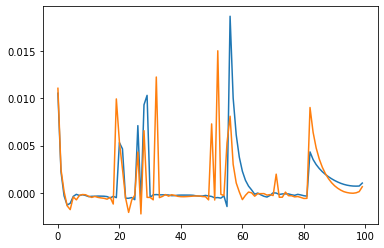

In [50]:
pd.Series(result_vwap.x.astype(np.float)/N).plot()
pd.Series(result_gss.x.astype(np.float)/N).plot()

<AxesSubplot:>

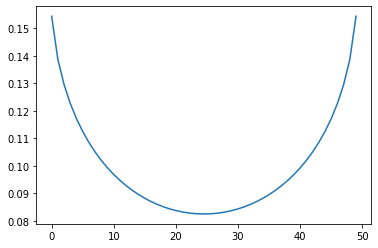

In [34]:
pd.Series(result_gss.x.astype(np.float)).plot()

In [36]:
sum(result_vwap.x)

5.000000000000002